In [1]:
import rdkit # compchem library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole # use this to draw molecules in the notebook
print(rdkit.__version__)

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

2024.09.3


Data for this exercise taken from the [DUD-E validation dataset](http://dude.docking.org/targets/try1).

In [2]:
def get_mols(smi_file):
    mols = []
    with open(smi_file) as f:
        for l in f:
            mols.append(l.split()[0])
    return mols

In [3]:
n = 200 # balance sets equally
actives = [ Chem.MolFromSmiles(m) for m in get_mols('./data/try1_actives_final.ism')[:n] ]
decoys = [ Chem.MolFromSmiles(m) for m in get_mols('./data/try1_decoys_final.ism')[:n] ]

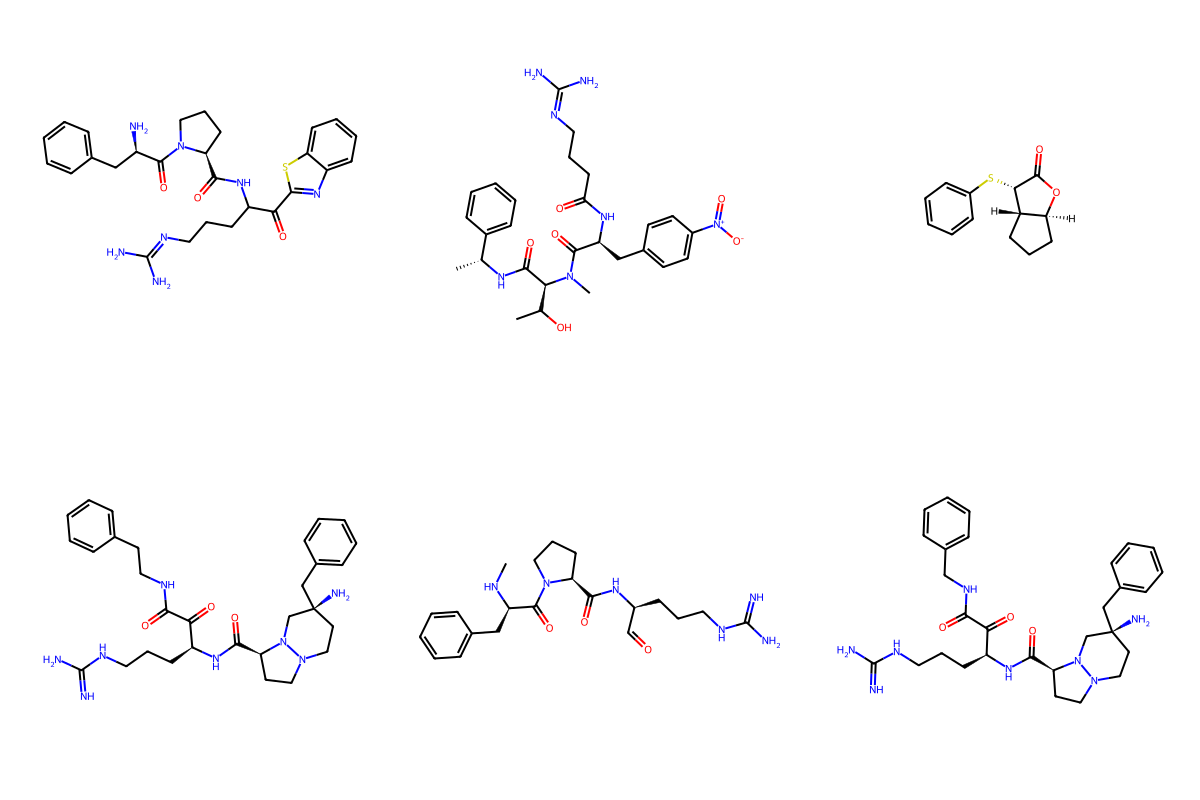

In [4]:
img = Draw.MolsToGridImage( actives[:6], molsPerRow=3, subImgSize=(400, 400))
img

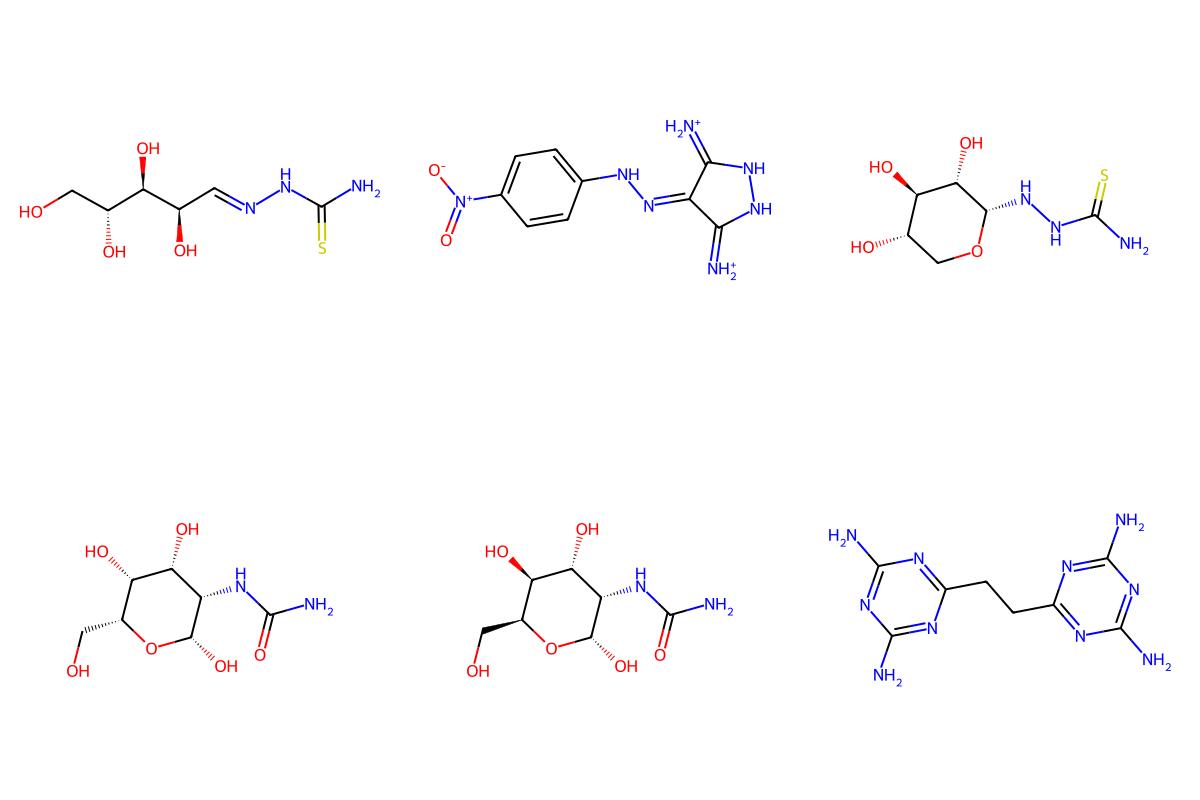

In [5]:
img = Draw.MolsToGridImage( decoys[:6], molsPerRow=3, subImgSize=(400, 400))
img

We need to generate properties for each molecule in the actives and decoy testing sets

In [6]:
mol = pd.Series(decoys + actives)
target_classes = np.array(['DECOY', 'ACTIVE'])
mol_labels = pd.Series(([target_classes[0]] * n) + ([target_classes[1]] * n))
df = pd.DataFrame()
df['molecule'] = mol
df['class'] = mol_labels
df['mol_weight'] = [ Descriptors.MolWt(m) for m in df['molecule'] ]
df['rot_bonds'] =  [ Descriptors.NumRotatableBonds(m) for m in df['molecule'] ]
df['h_donors'] =   [ Descriptors.NumHDonors(m) for m in df['molecule'] ]
df['h_acceptors'] = [ Descriptors.NumHAcceptors(m) for m in df['molecule'] ]
df['log_p'] = [ Descriptors.MolLogP(m) for m in df['molecule'] ]
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
0,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c430>,DECOY,223.254,5,6,6,-3.11960,True
1,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c350>,DECOY,249.234,3,5,4,-3.21430,False
2,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c3c0>,DECOY,223.254,2,6,6,-3.23680,False
3,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c4a0>,DECOY,222.197,2,6,6,-3.54540,True
4,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c580>,DECOY,222.197,2,6,6,-3.54540,False
...,...,...,...,...,...,...,...,...
395,<rdkit.Chem.rdchem.Mol object at 0x76069bd522d0>,ACTIVE,519.645,11,3,4,5.40077,True
396,<rdkit.Chem.rdchem.Mol object at 0x76069bd52340>,ACTIVE,494.643,7,3,5,5.43844,True
397,<rdkit.Chem.rdchem.Mol object at 0x76069bd523b0>,ACTIVE,494.573,7,3,7,2.56277,False
398,<rdkit.Chem.rdchem.Mol object at 0x76069bd52420>,ACTIVE,507.572,8,4,7,2.43337,True


In [7]:
train, test = df[df['is_train'] == True], df[df['is_train'] == False]

In [8]:
train.head()

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
0,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c430>,DECOY,223.254,5,6,6,-3.1196,True
3,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c4a0>,DECOY,222.197,2,6,6,-3.5454,True
6,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c5f0>,DECOY,222.197,2,6,6,-3.5454,True
7,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c660>,DECOY,342.297,4,8,11,-5.3972,True
8,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c6d0>,DECOY,232.328,4,4,2,-2.3332,True


In [9]:
test.head()

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
1,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c350>,DECOY,249.234,3,5,4,-3.2143,False
2,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c3c0>,DECOY,223.254,2,6,6,-3.2368,False
4,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c580>,DECOY,222.197,2,6,6,-3.5454,False
5,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c510>,DECOY,248.254,3,4,10,-1.8294,False
9,<rdkit.Chem.rdchem.Mol object at 0x76069bd4c7b0>,DECOY,322.334,3,8,8,-5.2391,False


In [10]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 296
Number of observations in the test data: 104


In [11]:
features = df.columns[2:7]

# View features names
features

Index(['mol_weight', 'rot_bonds', 'h_donors', 'h_acceptors', 'log_p'], dtype='object')

In [12]:
y = pd.factorize(train['class'])
y # training classes

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
clf = RandomForestClassifier(n_estimators=100)

If you want a (Gaussian) Naive Bayes instead ...

```python
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
```

In [14]:
model = clf.fit(train[features], y[0])

In [15]:
predictions = clf.predict(test[features])
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
clf.predict_proba(test[features])[:10]

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.6 , 0.4 ]])

In [17]:
preds = target_classes[predictions]
preds

array(['DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'ACTIVE', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'ACTIVE', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'DECOY', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'AC

In [18]:
# confusion matrix
pd.crosstab(test['class'], preds, rownames=['Actual Class'], colnames=['Predicted Class'])

Predicted Class,ACTIVE,DECOY
Actual Class,,
ACTIVE,54,1
DECOY,2,47


In [19]:
from sklearn import metrics
# accuracy
accuracy_score = metrics.accuracy_score(test['class'], preds)
print(accuracy_score)
# f1 score
f1_score = metrics.f1_score(test['class'], preds, pos_label="ACTIVE")
print(f1_score)

0.9711538461538461
0.972972972972973


Average precision-recall score: 0.96


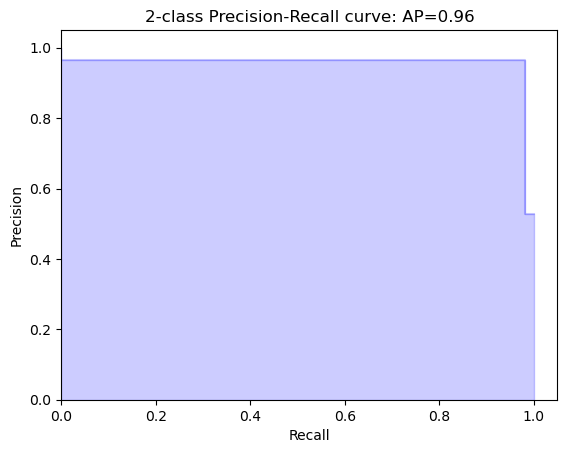

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

numeric_preds = [1 if cls == "ACTIVE" else 0 for cls in test['class']]

precision, recall, _ = precision_recall_curve(numeric_preds, predictions)

average_precision = average_precision_score(numeric_preds, predictions)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt;


In [21]:
list(zip(train[features], clf.feature_importances_))

[('mol_weight', np.float64(0.3329785436296129)),
 ('rot_bonds', np.float64(0.12119781685473699)),
 ('h_donors', np.float64(0.06288952497368601)),
 ('h_acceptors', np.float64(0.20358774620880965)),
 ('log_p', np.float64(0.27934636833315457))]

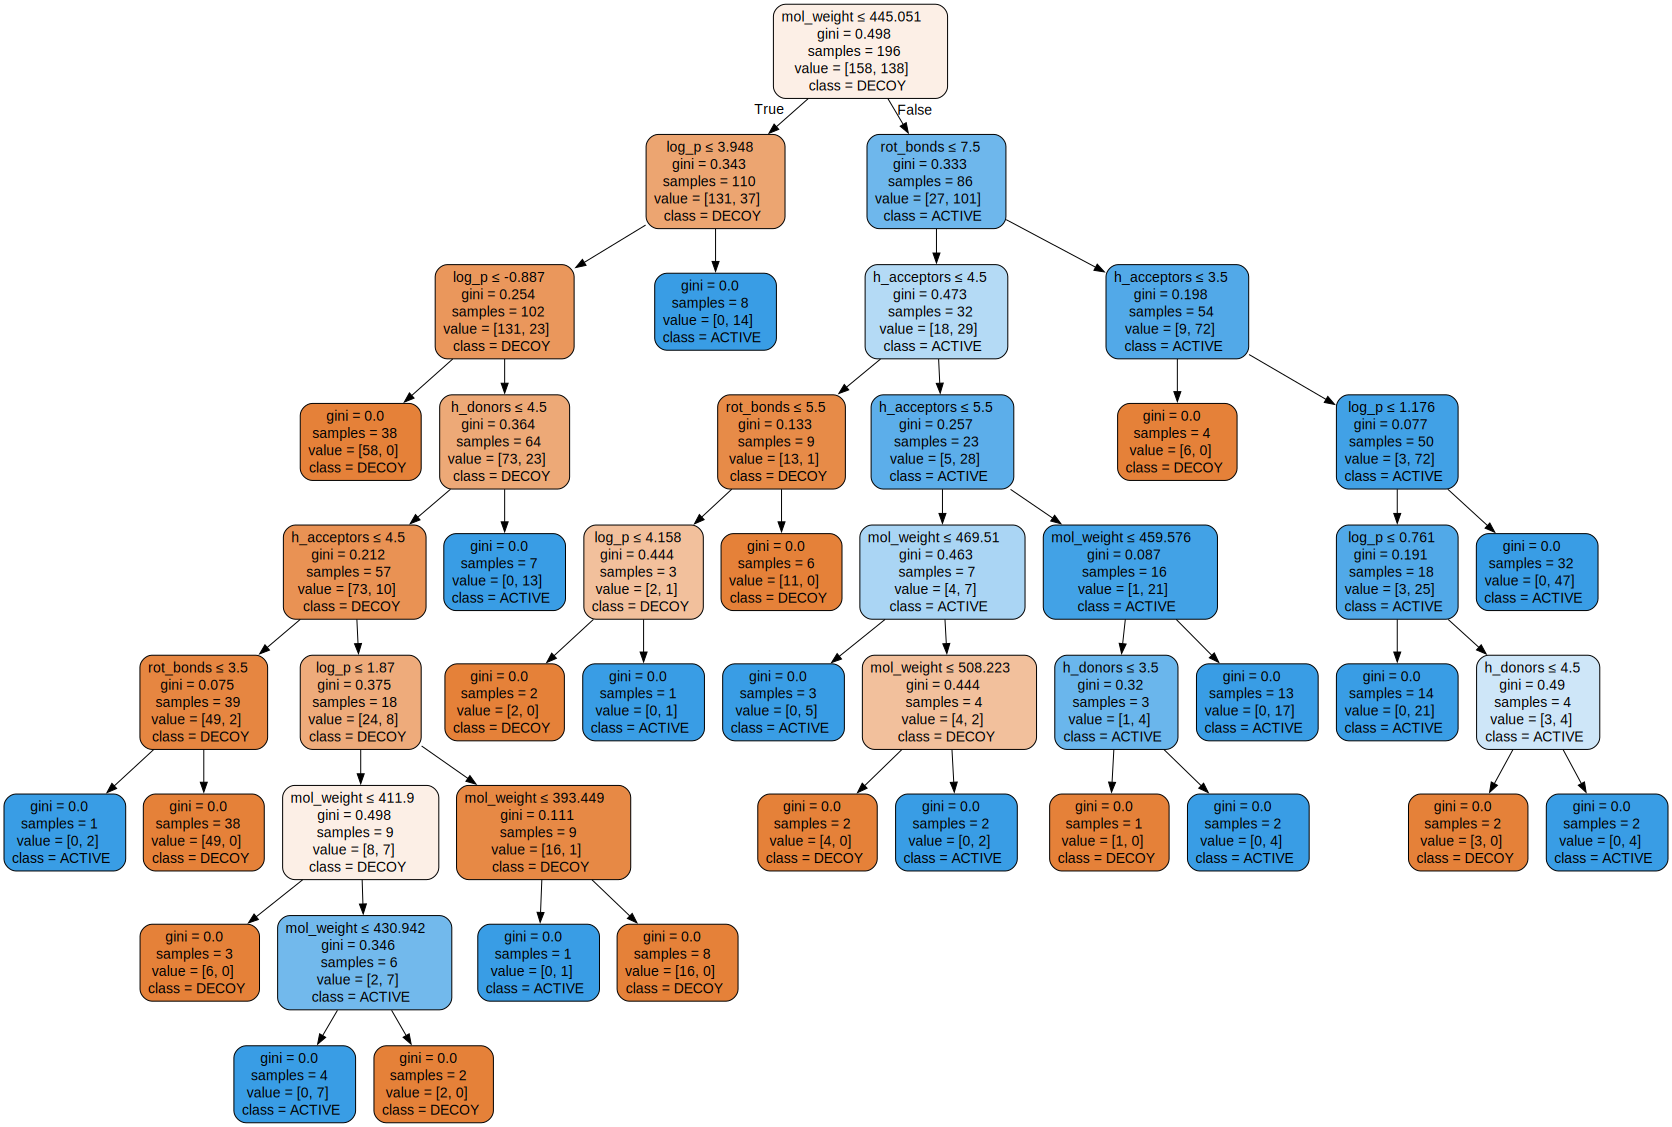

In [22]:
from sklearn import tree
import graphviz

# just one three for an example
trees =  [estimator for estimator in clf.estimators_]
single_tree = trees[0]

dot_data = tree.export_graphviz(single_tree, out_file=None, 
                         feature_names=features,  
                         class_names=target_classes,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


# Practical Tasks

You are required to:

* Compute Accuracy of Model (plot a ROC curve)
* Build a Naive Bayes Classifier Model
* Test the models on more data (what is the accuracy?)
* Investigate the use of more training data
* Investigate the use of unbalanced sets for 
    1. Training
    2. Testing
